# Simulación de curvas de luz periódicas

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt

from torch.utils.data import Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generación de curvas de luz

### Visualización de curvas

In [5]:
def plot_periodic(mjd, mag, P, ax):
    ax[0].plot(mjd, mag, '.')
    ax[0].set_xlabel('Tiempo')
    ax[1].plot(np.mod(mjd, P)/P, mag, '.')
    ax[1].set_xlabel('Fase');

### Señal cuadrada

In [6]:
def random_periodic_square_signal(period, N=100, s_noise=0.2):
    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = signal.square(2 * np.pi * mjd/period) 
    mag += np.random.randn(N)*s_noise
    return mjd, mag

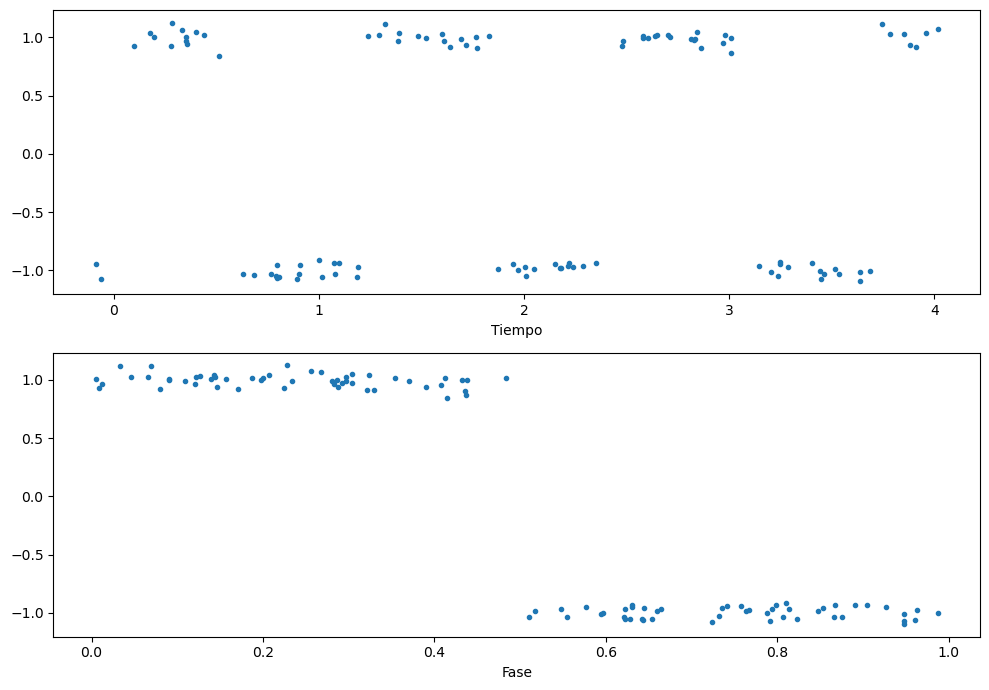

In [7]:
P = 1.234
mjd, mag = random_periodic_square_signal(P, s_noise=0.05)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Señal triangular

In [8]:
def random_periodic_triang_signal(period, N=100, s_noise=0.2):
    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = signal.sawtooth(2 * np.pi * mjd/period) 
    mag += np.random.randn(N)*s_noise
    return mjd, mag

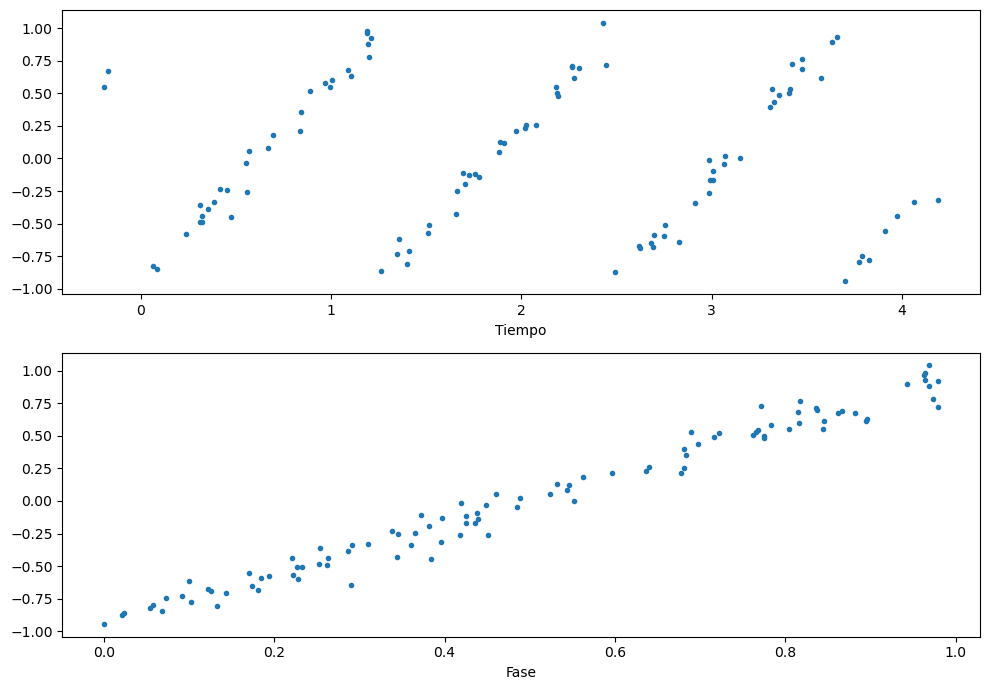

In [9]:
P = 1.234
mjd, mag = random_periodic_triang_signal(P, s_noise=0.1)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Suma de sinusoides

In [10]:
def random_periodic_light_curve(period, N=100, s_noise=0.2):

    mjd = np.linspace(0, 4, num=N, dtype=np.float32)
    mjd += np.random.randn(N)*0.1
    mjd = np.sort(mjd)
    mag = np.sin(2.0*np.pi*mjd/period) + 0.5*np.sin(2.0*np.pi*2*mjd/period)  + 0.25*np.sin(2.0*np.pi*3*mjd/period)
    mag += np.random.randn(N)*s_noise
    return mjd, mag

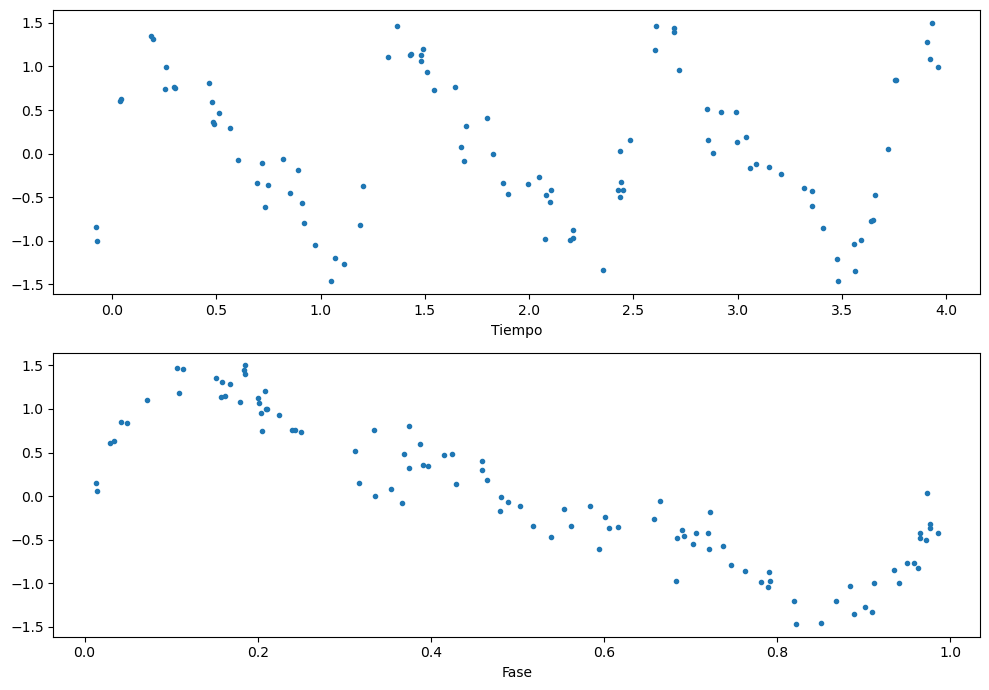

In [11]:
P = 1.234
mjd, mag = random_periodic_light_curve(P)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Adaptación a dataset de Pytorch

### Dataset class

In [12]:
class lc_dataset(Dataset):
    def __init__(self, N, curve_generator, seed=42, min_period=0.01, max_period=5):
        # Set seed
        self.seed = seed
        np.random.seed(self.seed)

        # Configure generators
        self.N = N
        self.curve_generator = curve_generator
        self.min_period = min_period
        self.max_period = max_period

        
        # Generate curves
        self.period_list = self.generate_periods()
        self.mjd_list, self.mag_list = self.generate_curves()

    def generate_periods(self):
        random_period_list = []
        for idx in range(self.N):
            random_period = np.random.uniform(self.min_period, self.max_period)
            random_period_list.append(random_period)
        return random_period_list
        
    def generate_curves(self):
        mjd_list = []
        mag_list = []
        for period in self.period_list:
            mjd, mag = self.curve_generator(period, N=self.N)
            mjd_list.append(mjd)
            mag_list.append(mag)
        return mjd_list, mag_list

    def to_df(self):
        dataset_df = pd.DataFrame({'mjd':self.mjd_list,
                                    'mag':self.mag_list,
                                    'period':self.period_list})
        return dataset_df

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        curve_dict = {'mjd':self.mjd_list[idx],
                    'mag':self.mag_list[idx],
                    'period':self.period_list[idx]}
        return curve_dict

### Prueba

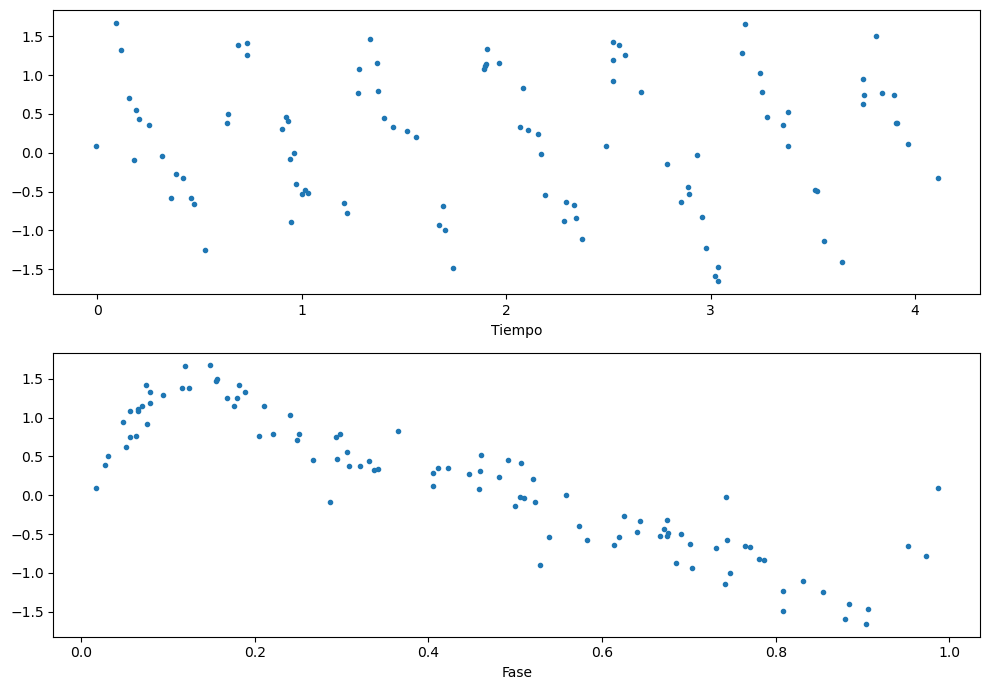

In [18]:
dataset = lc_dataset(100, random_periodic_light_curve)


fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
obj_id = 40
plot_periodic(*dataset.to_df().loc[obj_id].values, ax)